# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import glob

### load data

In [2]:
x_train = np.load('scripts_that_save/damped_pendulum_data_train.npy')
x_val = np.load('scripts_that_save/damped_pendulum_data_valid.npy')
x_test = np.load('scripts_that_save/damped_pendulum_data_test.npy')

kappas_tr, betas_tr = np.loadtxt('scripts_that_save/damped_pendulum_data_params_train.dat', unpack=True)
kappas_va, betas_va = np.loadtxt('scripts_that_save/damped_pendulum_data_params_valid.dat', unpack=True)
kappas_te, betas_te = np.loadtxt('scripts_that_save/damped_pendulum_data_params_test.dat', unpack=True)

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Neural Network

In [161]:
num_hidden_layers = 2
encoding_dim = 3
input_dim = x_train.shape[1]
hidden_dim = 100
batch_size = 1024
epochs = 1000
learning_rate = 0.01

regul=0.00018
regul2=0.00014

factor = 0.25
patience = 50
min_lr = 0.000001
verbose = 1

In [162]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='total_loss',
                                                 factor=factor,
                                                 patience=patience, 
                                                 min_lr=min_lr, 
                                                 verbose=verbose
                                                )

In [163]:
early_stopping_callback = EarlyStopping(
    patience=patience,
    monitor='total_loss',
    mode='min',
    verbose=verbose
)

## Autoencoder

In [164]:
# Autoencoder
encoder_input = keras.Input(shape=(input_dim,))

# Encoder
x = layers.Dense(5 * hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(encoder_input)
for i in range(num_hidden_layers):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
z_mean = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)
z_log_var = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)

z = Sampling()([z_mean, z_log_var])

# Decoder
decoder_input = keras.Input(shape=(encoding_dim,))
x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(decoder_input)
for i in range(num_hidden_layers):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
x = layers.Dense(5 * hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
decoded = layers.Dense(input_dim, activation='linear')(x)

# Define models
encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
decoder = keras.Model(decoder_input, decoded, name='decoder')
autoencoder = keras.Model(encoder_input, decoder(encoder(encoder_input)))

In [165]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='recon_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction),
                    axis=(-1))) 
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = recon_loss + kl_loss
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(recon_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "total_loss": self.total_loss_tracker.result(),
                "recon_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        z = self.sampler([z_mean, z_log_var])
        return self.decoder(z)

In [166]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), run_eagerly=True)

## training the model

In [167]:
fitting_output = vae.fit(x_train,
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[reduce_lr, early_stopping_callback]
                          )

Epoch 1/1000
14/14 [==============================] - 2s 103ms/step - total_loss: 113.9265 - recon_loss: 113.2823 - kl_loss: 0.6441 - lr: 0.0100
Epoch 2/1000
14/14 [==============================] - 1s 91ms/step - total_loss: 77.3239 - recon_loss: 73.7413 - kl_loss: 3.5825 - lr: 0.0100
Epoch 3/1000
14/14 [==============================] - 2s 111ms/step - total_loss: 42.1888 - recon_loss: 36.6466 - kl_loss: 5.5423 - lr: 0.0100
Epoch 4/1000
14/14 [==============================] - 1s 81ms/step - total_loss: 20.3513 - recon_loss: 14.2617 - kl_loss: 6.0896 - lr: 0.0100
Epoch 5/1000
14/14 [==============================] - 1s 85ms/step - total_loss: 13.3407 - recon_loss: 7.6382 - kl_loss: 5.7025 - lr: 0.0100
Epoch 6/1000
14/14 [==============================] - 1s 87ms/step - total_loss: 9.9190 - recon_loss: 4.3348 - kl_loss: 5.5842 - lr: 0.0100
Epoch 7/1000
14/14 [==============================] - 1s 84ms/step - total_loss: 8.6157 - recon_loss: 3.1316 - kl_loss: 5.4842 - lr: 0.0100
Epoch 8

14/14 [==============================] - 1s 81ms/step - total_loss: 6.5918 - recon_loss: 1.5030 - kl_loss: 5.0887 - lr: 0.0100
Epoch 60/1000
14/14 [==============================] - 1s 80ms/step - total_loss: 6.7267 - recon_loss: 1.6219 - kl_loss: 5.1048 - lr: 0.0100
Epoch 61/1000
14/14 [==============================] - 1s 81ms/step - total_loss: 6.7491 - recon_loss: 1.6517 - kl_loss: 5.0973 - lr: 0.0100
Epoch 62/1000
14/14 [==============================] - 1s 80ms/step - total_loss: 6.6431 - recon_loss: 1.4641 - kl_loss: 5.1790 - lr: 0.0100
Epoch 63/1000
14/14 [==============================] - 1s 80ms/step - total_loss: 6.6165 - recon_loss: 1.4664 - kl_loss: 5.1500 - lr: 0.0100
Epoch 64/1000
14/14 [==============================] - 1s 84ms/step - total_loss: 6.5296 - recon_loss: 1.4623 - kl_loss: 5.0673 - lr: 0.0100
Epoch 65/1000
14/14 [==============================] - 1s 82ms/step - total_loss: 6.4670 - recon_loss: 1.3781 - kl_loss: 5.0890 - lr: 0.0100
Epoch 66/1000
14/14 [======

14/14 [==============================] - 1s 89ms/step - total_loss: 6.3440 - recon_loss: 1.3327 - kl_loss: 5.0112 - lr: 0.0100
Epoch 118/1000
14/14 [==============================] - 1s 97ms/step - total_loss: 6.4855 - recon_loss: 1.5434 - kl_loss: 4.9421 - lr: 0.0100
Epoch 119/1000
14/14 [==============================] - 1s 86ms/step - total_loss: 6.5911 - recon_loss: 1.6030 - kl_loss: 4.9881 - lr: 0.0100
Epoch 120/1000
14/14 [==============================] - 1s 80ms/step - total_loss: 6.4118 - recon_loss: 1.4104 - kl_loss: 5.0014 - lr: 0.0100
Epoch 121/1000
14/14 [==============================] - 1s 80ms/step - total_loss: 6.5772 - recon_loss: 1.6010 - kl_loss: 4.9762 - lr: 0.0100
Epoch 122/1000
14/14 [==============================] - 1s 80ms/step - total_loss: 6.3506 - recon_loss: 1.3720 - kl_loss: 4.9787 - lr: 0.0100
Epoch 123/1000
14/14 [==============================] - 1s 83ms/step - total_loss: 6.2726 - recon_loss: 1.3326 - kl_loss: 4.9400 - lr: 0.0100
Epoch 124/1000
14/14 

14/14 [==============================] - 4s 245ms/step - total_loss: 6.7725 - recon_loss: 1.8325 - kl_loss: 4.9401 - lr: 0.0100
Epoch 175/1000
14/14 [==============================] - 3s 193ms/step - total_loss: 6.2976 - recon_loss: 1.3111 - kl_loss: 4.9865 - lr: 0.0100
Epoch 176/1000
14/14 [==============================] - 3s 245ms/step - total_loss: 6.4120 - recon_loss: 1.4683 - kl_loss: 4.9437 - lr: 0.0100
Epoch 177/1000
14/14 [==============================] - 3s 227ms/step - total_loss: 6.3238 - recon_loss: 1.3890 - kl_loss: 4.9348 - lr: 0.0100
Epoch 178/1000
14/14 [==============================] - 3s 186ms/step - total_loss: 6.1829 - recon_loss: 1.2389 - kl_loss: 4.9441 - lr: 0.0100
Epoch 179/1000
14/14 [==============================] - 3s 180ms/step - total_loss: 6.2868 - recon_loss: 1.3224 - kl_loss: 4.9644 - lr: 0.0100
Epoch 180/1000
14/14 [==============================] - 3s 188ms/step - total_loss: 6.2031 - recon_loss: 1.2531 - kl_loss: 4.9500 - lr: 0.0100
Epoch 181/1000

14/14 [==============================] - 2s 161ms/step - total_loss: 6.1474 - recon_loss: 1.2198 - kl_loss: 4.9277 - lr: 0.0100
Epoch 232/1000
14/14 [==============================] - 2s 168ms/step - total_loss: 6.1628 - recon_loss: 1.2144 - kl_loss: 4.9483 - lr: 0.0100
Epoch 233/1000
14/14 [==============================] - 3s 195ms/step - total_loss: 6.2121 - recon_loss: 1.2692 - kl_loss: 4.9429 - lr: 0.0100
Epoch 234/1000
14/14 [==============================] - 3s 186ms/step - total_loss: 6.2073 - recon_loss: 1.2138 - kl_loss: 4.9935 - lr: 0.0100
Epoch 235/1000
14/14 [==============================] - 3s 196ms/step - total_loss: 6.3004 - recon_loss: 1.3405 - kl_loss: 4.9599 - lr: 0.0100
Epoch 236/1000
14/14 [==============================] - 2s 171ms/step - total_loss: 6.3529 - recon_loss: 1.4145 - kl_loss: 4.9384 - lr: 0.0100
Epoch 237/1000
14/14 [==============================] - 2s 163ms/step - total_loss: 6.2449 - recon_loss: 1.2934 - kl_loss: 4.9515 - lr: 0.0100
Epoch 238/1000

14/14 [==============================] - 3s 232ms/step - total_loss: 6.1936 - recon_loss: 1.2362 - kl_loss: 4.9574 - lr: 0.0100
Epoch 289/1000
14/14 [==============================] - 3s 216ms/step - total_loss: 6.2258 - recon_loss: 1.3163 - kl_loss: 4.9094 - lr: 0.0100
Epoch 290/1000
14/14 [==============================] - 4s 279ms/step - total_loss: 6.2591 - recon_loss: 1.2829 - kl_loss: 4.9762 - lr: 0.0100
Epoch 291/1000
14/14 [==============================] - 4s 268ms/step - total_loss: 6.4874 - recon_loss: 1.4347 - kl_loss: 5.0527 - lr: 0.0100
Epoch 292/1000
14/14 [==============================] - 3s 224ms/step - total_loss: 6.3486 - recon_loss: 1.3423 - kl_loss: 5.0063 - lr: 0.0100
Epoch 293/1000
14/14 [==============================] - 4s 263ms/step - total_loss: 6.1817 - recon_loss: 1.2086 - kl_loss: 4.9731 - lr: 0.0100
Epoch 294/1000
14/14 [==============================] - 3s 235ms/step - total_loss: 6.1932 - recon_loss: 1.2308 - kl_loss: 4.9624 - lr: 0.0100
Epoch 295/1000

14/14 [==============================] - 1s 86ms/step - total_loss: 6.2636 - recon_loss: 1.3224 - kl_loss: 4.9411 - lr: 0.0100
Epoch 346/1000
14/14 [==============================] - 1s 95ms/step - total_loss: 6.2418 - recon_loss: 1.2445 - kl_loss: 4.9973 - lr: 0.0100
Epoch 347/1000
14/14 [==============================] - 1s 84ms/step - total_loss: 6.2290 - recon_loss: 1.3236 - kl_loss: 4.9054 - lr: 0.0100
Epoch 348/1000
14/14 [==============================] - 1s 91ms/step - total_loss: 6.1261 - recon_loss: 1.2133 - kl_loss: 4.9128 - lr: 0.0100
Epoch 349/1000
14/14 [==============================] - 3s 190ms/step - total_loss: 6.1404 - recon_loss: 1.1806 - kl_loss: 4.9599 - lr: 0.0100
Epoch 350/1000
14/14 [==============================] - 3s 201ms/step - total_loss: 6.1538 - recon_loss: 1.2139 - kl_loss: 4.9399 - lr: 0.0100
Epoch 351/1000
14/14 [==============================] - 2s 156ms/step - total_loss: 6.2355 - recon_loss: 1.2388 - kl_loss: 4.9967 - lr: 0.0100
Epoch 352/1000
14/

In [168]:
training_history = fitting_output.history

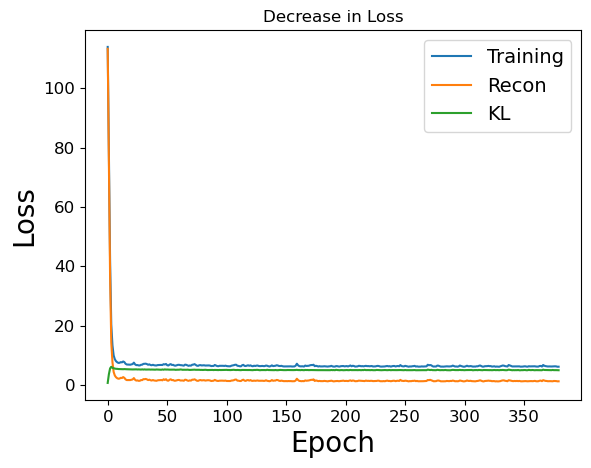

In [169]:
# plotting the decrease in loss as the network learns
fig_loss = plt.figure()
ax = fig_loss.add_subplot(111)
ax.plot(fitting_output.history['total_loss'], label='Training')
ax.plot(fitting_output.history['recon_loss'], label='Recon')
ax.plot(fitting_output.history['kl_loss'], label='KL')
ax.set_title('Decrease in Loss')
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
# ax.set_xticks(np.arange(0, epochs))
#ax.set_ylim(0, 0.3)
plt.show()

## testing the model

In [170]:
# compare autoencoder model to encoder and decoder models

# f1 = autoencoder.predict(x_test)
f2 = decoder(encoder(x_test)[2])

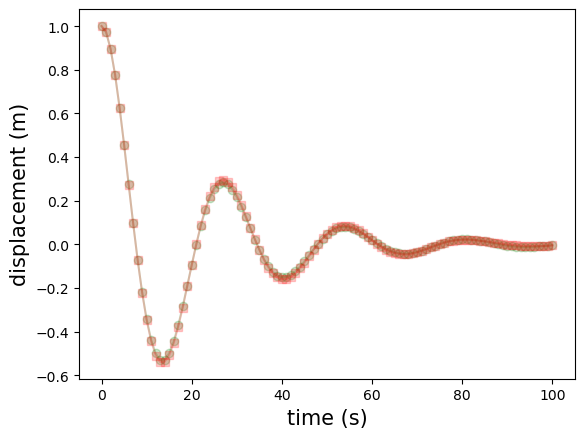

In [178]:
sample = 20

plt.plot(x_test[sample], color='g', marker='o', alpha=0.2)
# plt.plot(f1[sample], color='b', marker='*', alpha=0.2)
plt.plot(f2[sample], color='r', marker='s', alpha=0.2)
plt.xlabel('time (s)', fontsize=fontsize)
plt.ylabel('displacement (m)', fontsize=fontsize)
plt.savefig('recreated_data_VAE')

In [172]:
encoded_data = encoder.predict(x_test)[2]

63/63 [==============================] - 0s 3ms/step


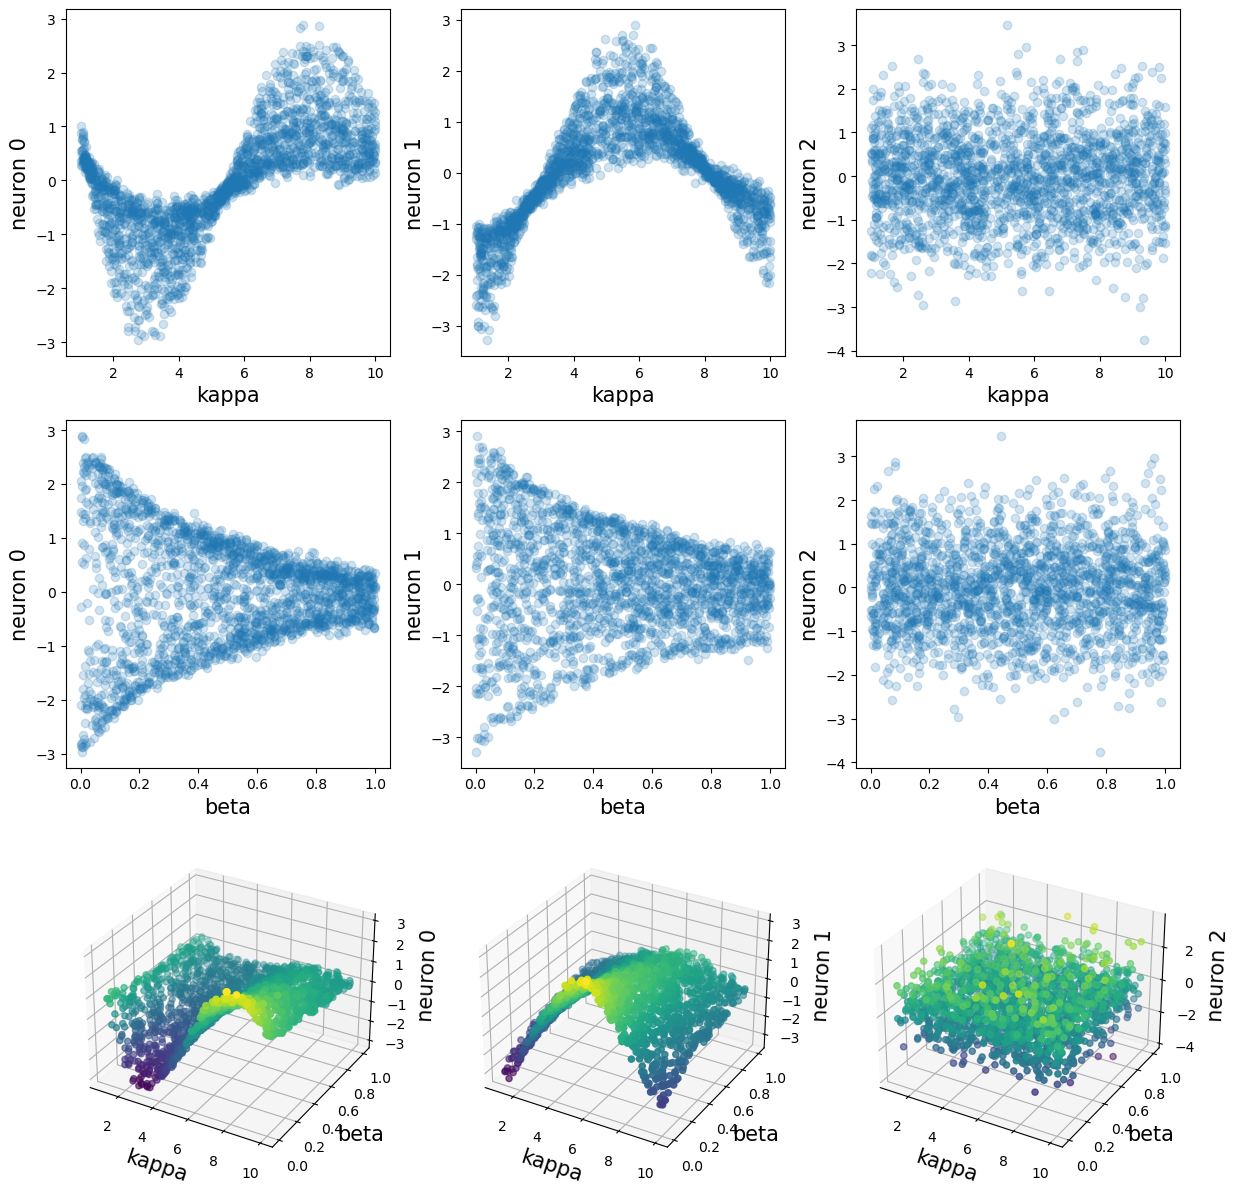

In [175]:
graphs = 'graphs_for_report'
save_path = f"new_batch:{batch_size}_lr:{learning_rate}_regul:{regul}_regul2:{regul2}_VAE_q_cl"

fontsize = 15

fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(331)
ax1.plot(kappas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax1.set_xlabel('kappa', fontsize=fontsize)
ax1.set_ylabel('neuron 0', fontsize=fontsize)

ax2 = fig.add_subplot(334)
ax2.plot(betas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax2.set_xlabel('beta', fontsize=fontsize)
ax2.set_ylabel('neuron 0', fontsize=fontsize)

ax3 = fig.add_subplot(332)
ax3.plot(kappas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax3.set_xlabel('kappa', fontsize=fontsize)
ax3.set_ylabel('neuron 1', fontsize=fontsize)

ax4 = fig.add_subplot(335)
ax4.plot(betas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax4.set_xlabel('beta', fontsize=fontsize)
ax4.set_ylabel('neuron 1', fontsize=fontsize)

ax5 = fig.add_subplot(333)
ax5.plot(kappas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax5.set_xlabel('kappa', fontsize=fontsize)
ax5.set_ylabel('neuron 2', fontsize=fontsize)

ax6 = fig.add_subplot(336)
ax6.plot(betas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax6.set_xlabel('beta', fontsize=fontsize)
ax6.set_ylabel('neuron 2', fontsize=fontsize)

ax7 = fig.add_subplot(337, projection='3d')
ax7.scatter(kappas_te, betas_te, encoded_data[:, 0], c=encoded_data[:, 0])
ax7.set_xlabel('kappa', fontsize=fontsize)
ax7.set_ylabel('beta', fontsize=fontsize)
ax7.set_zlabel('neuron 0', fontsize=fontsize)

ax8 = fig.add_subplot(338, projection='3d')
ax8.scatter(kappas_te, betas_te, encoded_data[:, 1], c=encoded_data[:, 1])
ax8.set_xlabel('kappa', fontsize=fontsize)
ax8.set_ylabel('beta', fontsize=fontsize)
ax8.set_zlabel('neuron 1', fontsize=fontsize)

ax9 = fig.add_subplot(339, projection='3d')
ax9.scatter(kappas_te, betas_te, encoded_data[:, 2], c=encoded_data[:, 2])
ax9.set_xlabel('kappa', fontsize=fontsize)
ax9.set_ylabel('beta', fontsize=fontsize)
ax9.set_zlabel('neuron 2', fontsize=fontsize)

plt.tight_layout()
graphs_file_path = os.path.join(graphs, save_path)
plt.savefig(os.path.join(f"{graphs_file_path}.png"))
plt.show()
plt.close(fig)